# BIOL550 Lab 3 Report (Cuffdiff + downstream analysis)

Reads the exported `cuffdiff` results in `lab3/exports/` and generates a couple of DE tables + figures for the Trapnell DE submission.


## Paths

Sets `ROOT` and the key file paths used throughout the notebook, and verifies the `cuffdiff` outputs exist locally.


In [1]:
from __future__ import annotations

from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image, display

ROOT = Path("/Users/pitergarcia/DataScience")

lab3 = ROOT / "Semester5/BIOL550/BIOL550-Lab/lab3"
cuffdir = lab3 / "exports/cuffdiff_classref_v2_xs"
data_dir = lab3 / "data"
fig_dir = lab3 / "figures"
notes_dir = lab3 / "notes"

for p in (data_dir, fig_dir, notes_dir):
    p.mkdir(parents=True, exist_ok=True)

gene_exp = cuffdir / "gene_exp.diff"
read_group = cuffdir / "genes.read_group_tracking"

if not gene_exp.exists():
    raise FileNotFoundError(
        f"Missing {gene_exp}. Make sure you exported cuffdiff results into lab3/exports/ first."
    )

gene_exp


PosixPath('/Users/pitergarcia/DataScience/Semester5/BIOL550/BIOL550-Lab/lab3/exports/cuffdiff_classref_v2_xs/gene_exp.diff')

## Submission (Trapnell final — differential expression results)

Creates the myCourses-ready zip (`lab3/cuffdiff_results.zip`) containing **only** the `cuffdiff_classref_v2_xs/` directory.


In [ ]:
from __future__ import annotations

import os
import zipfile
from pathlib import Path

# Inputs
src_dir = cuffdir  # lab3/exports/cuffdiff_classref_v2_xs
if not src_dir.exists():
    raise FileNotFoundError(src_dir)

# Output zip (top-level folder should be cuffdiff_classref_v2_xs/)
out_zip = lab3 / "cuffdiff_results.zip"

# Rebuild zip deterministically
if out_zip.exists():
    out_zip.unlink()

with zipfile.ZipFile(out_zip, "w", compression=zipfile.ZIP_DEFLATED, compresslevel=6) as z:
    for path in sorted(src_dir.rglob("*")):
        if path.is_dir():
            continue
        arcname = str(Path(src_dir.name) / path.relative_to(src_dir))
        z.write(path, arcname=arcname)

print("Wrote:", out_zip)
print("Size:", f"{out_zip.stat().st_size/1024/1024:.2f} MB")


## Load `gene_exp.diff` and compute basic counts

Loads the gene-level DE table, filters to `status == OK`, and counts significant genes using `q_value <= 0.05`.


In [2]:
d = pd.read_csv(gene_exp, sep="\t")
d = d[d["status"] == "OK"].copy()

for col in ["p_value", "q_value", "log2(fold_change)", "value_1", "value_2"]:
    if col in d.columns:
        d[col] = pd.to_numeric(d[col], errors="coerce")

d = d.dropna(subset=["p_value", "q_value", "log2(fold_change)"])

sig = d[d["q_value"] <= 0.05].copy()

print("OK tests:", len(d))
print("Significant (q<=0.05):", len(sig))

sig[["gene", "gene_id", "log2(fold_change)", "p_value", "q_value"]].head(10)


OK tests: 8289
Significant (q<=0.05): 265


,gene,gene_id,log2(fold_change),p_value,q_value
28,Ald,FBgn0000064,0.725206,0.00005,0.001678
32,Amy-d,FBgn0000078,-0.763323,0.00015,0.004993
70,brm,FBgn0000212,0.844249,0.00005,0.001678
74,Bsg25D,FBgn0000228,0.813227,0.00005,0.001678
79,by,FBgn0000244,1.273910,0.00005,0.001678
123,crc,FBgn0000370,1.446750,0.00005,0.001678
135,D1,FBgn0000412,1.257400,0.00005,0.001678
148,Dip-B,FBgn0000454,1.026790,0.00005,0.001678
171,E(bx),FBgn0000541,0.573884,0.00005,0.001678
191,ena,FBgn0000578,0.538381,0.00005,0.001678


## Save/Load the significant gene table

Writes `lab3/data/gene_exp_fdr0.05.tsv` (if missing) and reloads it so later steps use a stable, saved table.


In [3]:
sig_path = data_dir / "gene_exp_fdr0.05.tsv"
if not sig_path.exists():
    sig_sorted = sig.sort_values(["q_value", "log2(fold_change)"], ascending=[True, False])
    sig_sorted.to_csv(sig_path, sep="\t", index=False)

sig_tbl = pd.read_csv(sig_path, sep="\t")
sig_path, sig_tbl.shape


(PosixPath('/Users/pitergarcia/DataScience/Semester5/BIOL550/BIOL550-Lab/lab3/data/gene_exp_fdr0.05.tsv'),
 (265, 14))

## Volcano plot (interactive + saved)

Generates a volcano plot from `gene_exp.diff` and saves it to `lab3/figures/volcano_gene_exp_python.png`.


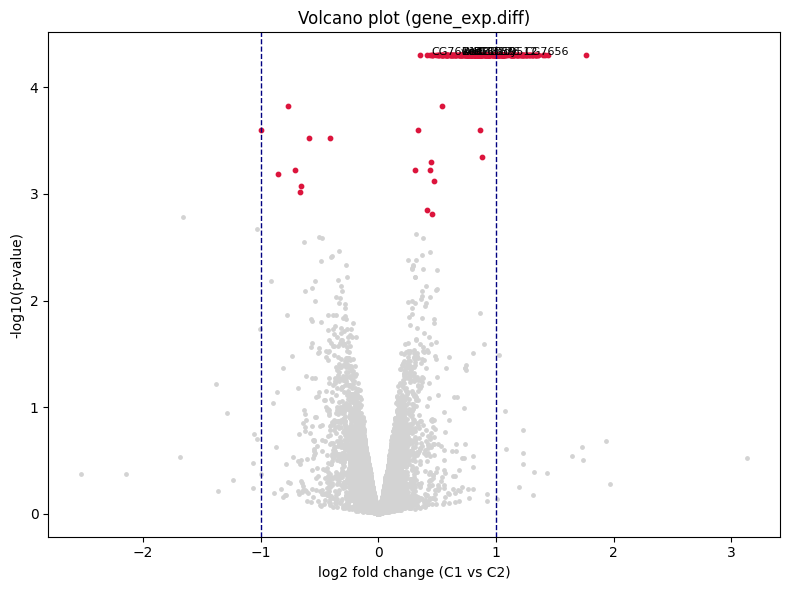

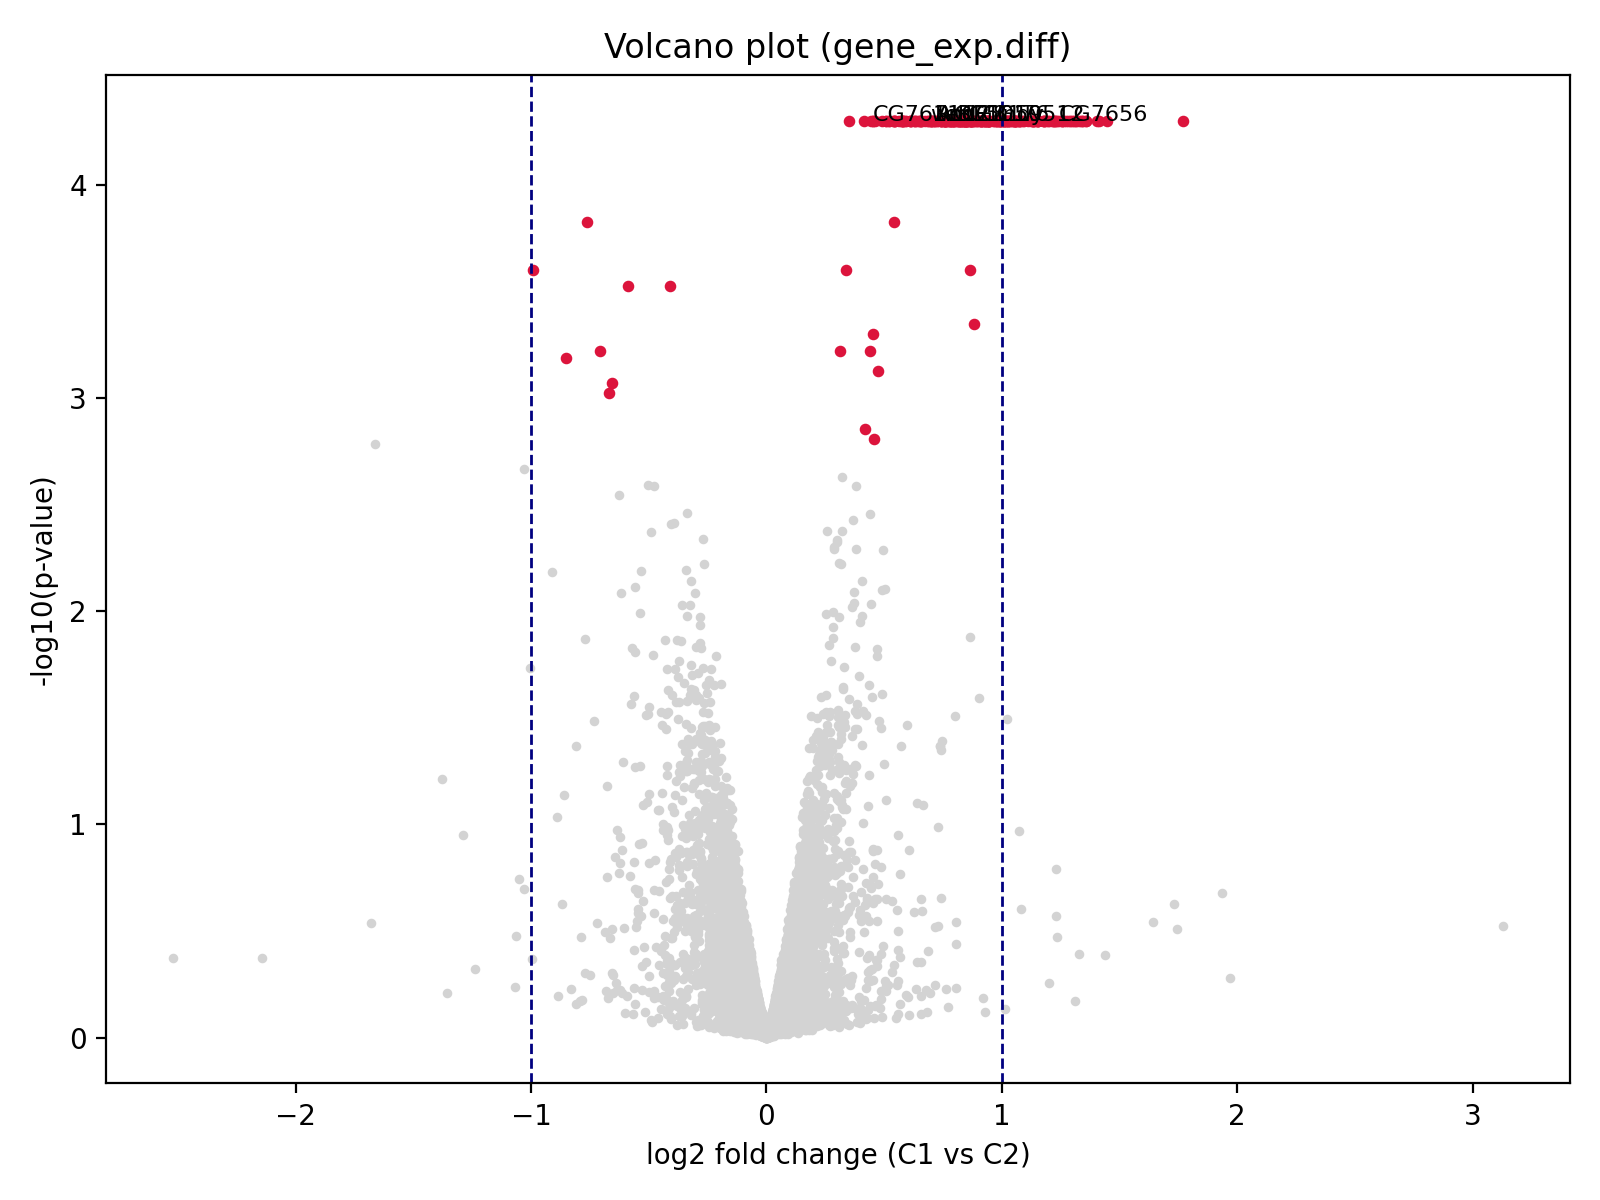

PosixPath('/Users/pitergarcia/DataScience/Semester5/BIOL550/BIOL550-Lab/lab3/figures/volcano_gene_exp_python.png')

In [4]:
volcano_out = fig_dir / "volcano_gene_exp_python.png"

plt.figure(figsize=(8, 6))
plt.scatter(d["log2(fold_change)"], -np.log10(d["p_value"]), s=6, c="lightgray")
plt.scatter(sig["log2(fold_change)"], -np.log10(sig["p_value"]), s=10, c="crimson")
plt.axvline(-1, ls="--", c="navy", lw=1)
plt.axvline(1, ls="--", c="navy", lw=1)
plt.xlabel("log2 fold change (C1 vs C2)")
plt.ylabel("-log10(p-value)")
plt.title("Volcano plot (gene_exp.diff)")

lab = sig.sort_values("q_value").head(10)
for _, r in lab.iterrows():
    plt.text(r["log2(fold_change)"], -np.log10(r["p_value"]), str(r.get("gene", "")), fontsize=8)

plt.tight_layout()
plt.savefig(volcano_out, dpi=200)
plt.show()

display(Image(filename=str(volcano_out)))
volcano_out


## Top 20 DE genes bar chart (saved)

Builds a simple bar chart of the top up/down DE genes (by log2FC) and saves it to `lab3/figures/top20_bar_log2fc.png`.


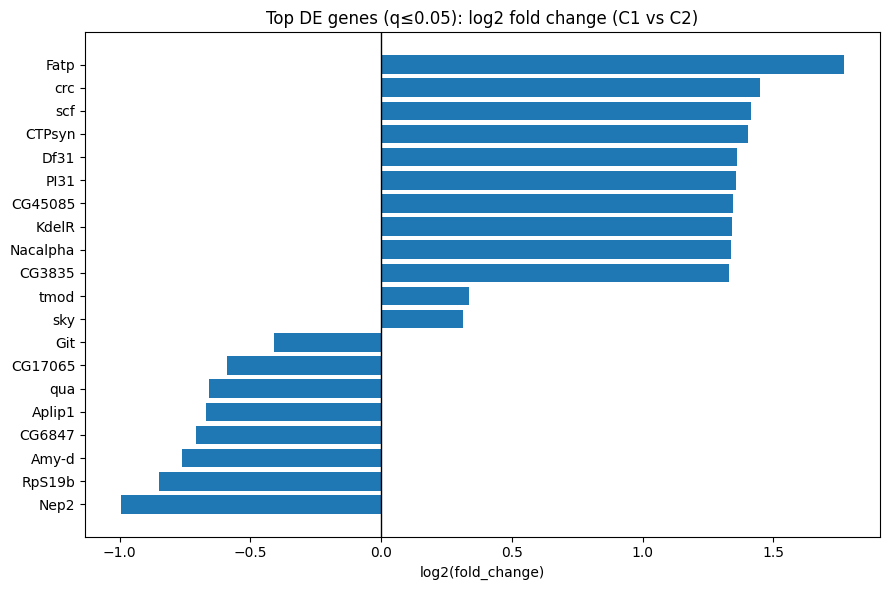

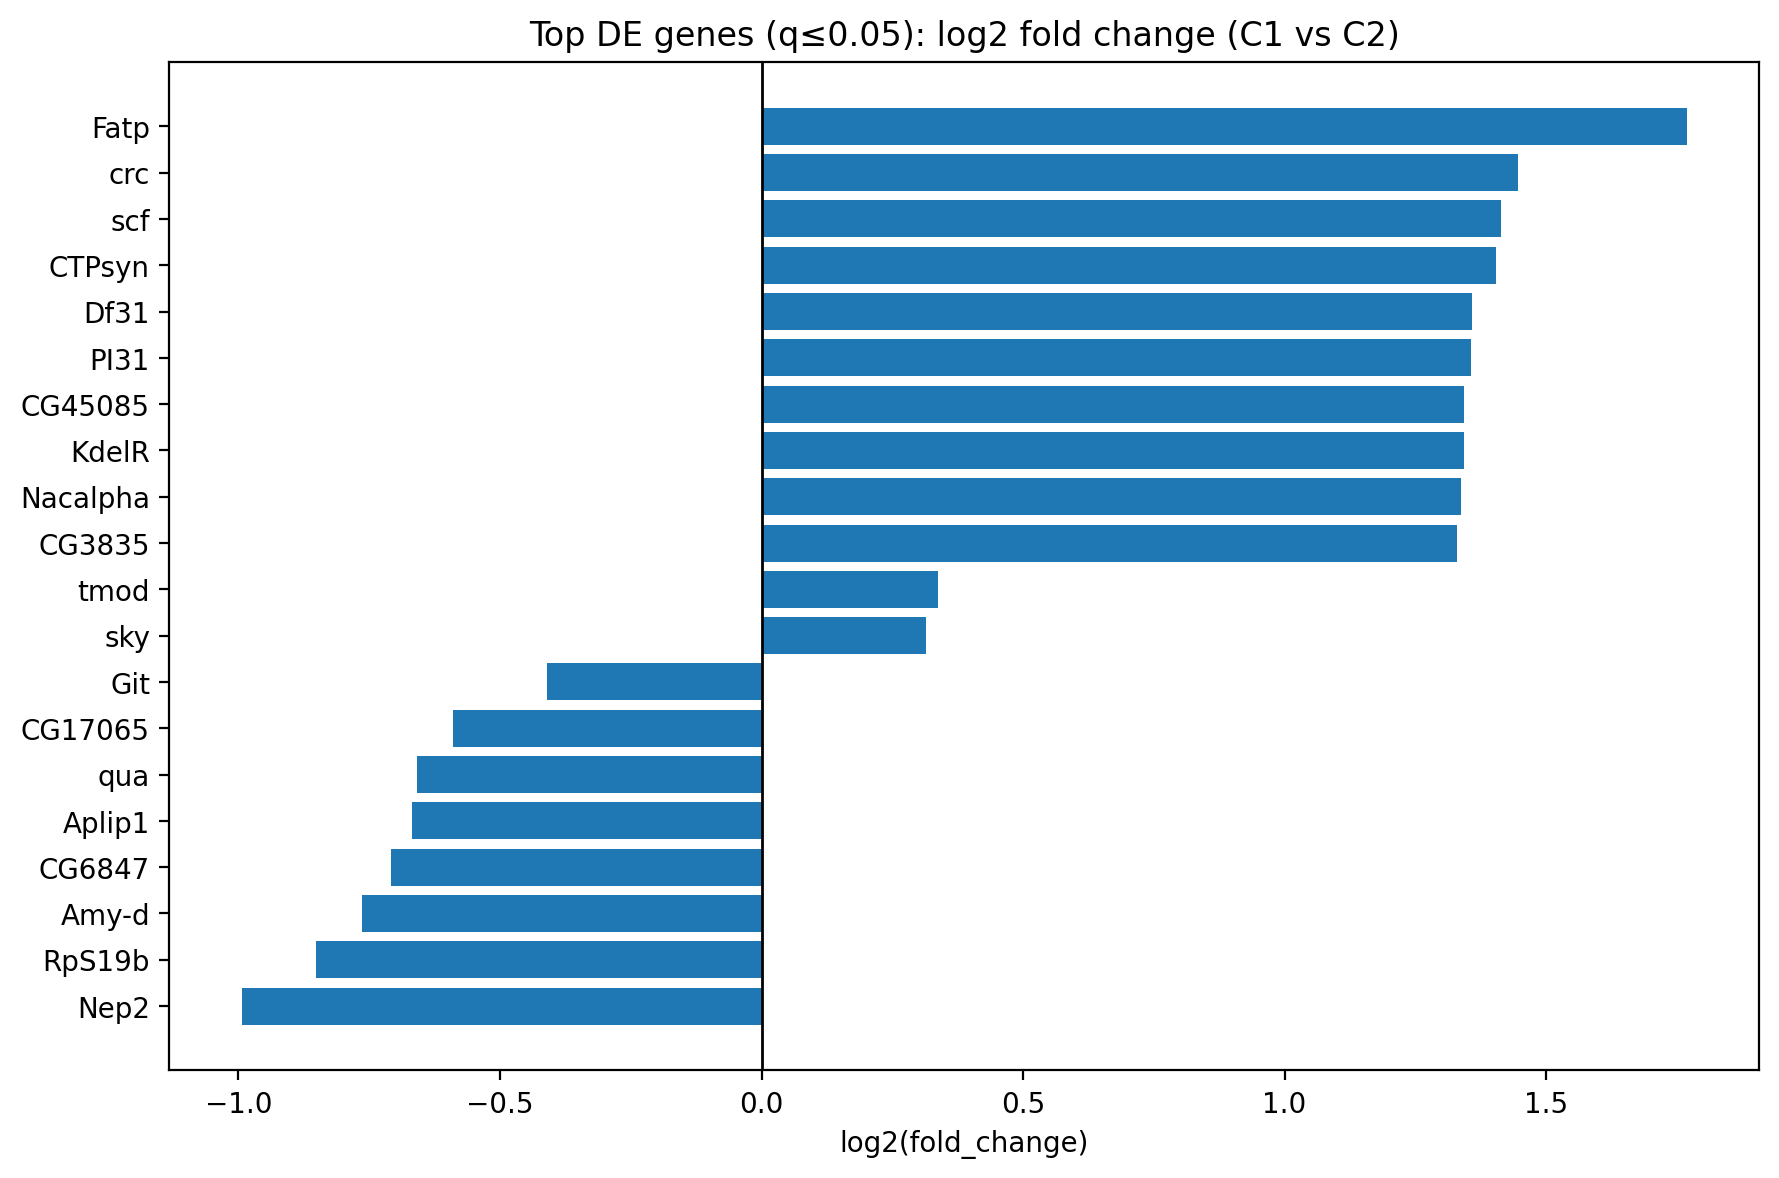

PosixPath('/Users/pitergarcia/DataScience/Semester5/BIOL550/BIOL550-Lab/lab3/figures/top20_bar_log2fc.png')

In [5]:
top20_out = fig_dir / "top20_bar_log2fc.png"

top = pd.concat([
    sig.sort_values("log2(fold_change)", ascending=False).head(10),
    sig.sort_values("log2(fold_change)", ascending=True).head(10),
]).copy()
top["label"] = top["gene"].fillna(top["gene_id"])
top = top.sort_values("log2(fold_change)")

fig, ax = plt.subplots(figsize=(9, 6))
ax.barh(top["label"], top["log2(fold_change)"])
ax.axvline(0, color="k", linewidth=1)
ax.set_title("Top DE genes (q≤0.05): log2 fold change (C1 vs C2)")
ax.set_xlabel("log2(fold_change)")
fig.tight_layout()
fig.savefig(top20_out, dpi=200, bbox_inches="tight")
plt.show()

display(Image(filename=str(top20_out)))
top20_out


## PCA of samples (replicates)

Uses `genes.read_group_tracking` to build a replicate expression matrix and runs PCA (via SVD) to sanity-check sample separation.


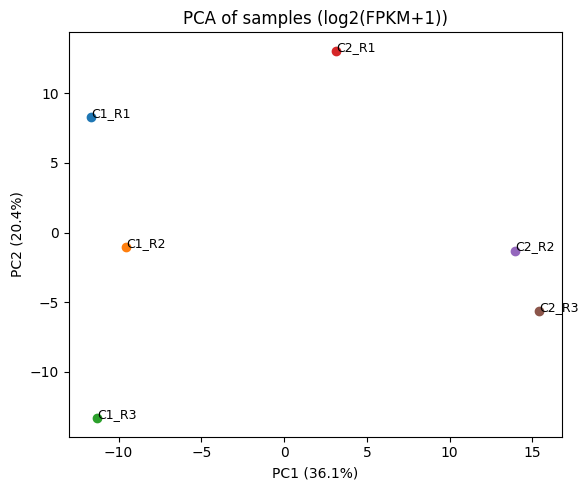

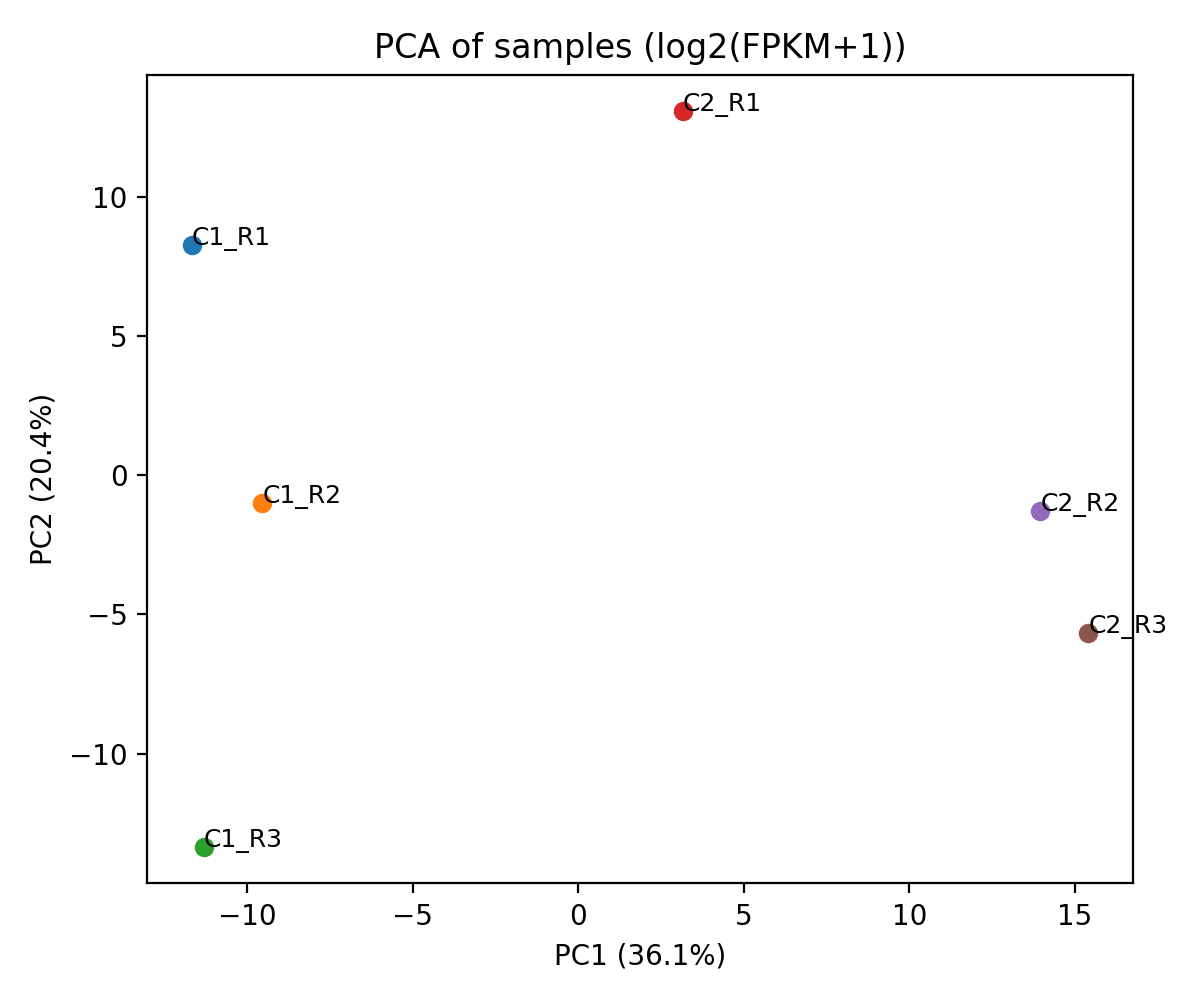

PosixPath('/Users/pitergarcia/DataScience/Semester5/BIOL550/BIOL550-Lab/lab3/figures/pca_samples.png')

In [7]:
pca_out = fig_dir / "pca_samples.png"

if not read_group.exists():
    raise FileNotFoundError(f"Missing {read_group}")

rg = pd.read_csv(read_group, sep="\t")
rg = rg[(rg["status"] == "OK")].copy()
rg["FPKM"] = pd.to_numeric(rg["FPKM"], errors="coerce")
rg = rg[rg["FPKM"].notna()].copy()
rg["sample"] = rg["condition"].astype(str) + "_R" + (rg["replicate"].astype(int) + 1).astype(str)

mat = rg.pivot_table(index="tracking_id", columns="sample", values="FPKM", fill_value=0.0)
X_df = np.log2(mat + 1.0).T  # samples x genes
X = X_df.to_numpy(dtype=float)

# PCA via SVD
Xc = X - X.mean(axis=0, keepdims=True)
U, S, Vt = np.linalg.svd(Xc, full_matrices=False)
Z = U[:, :2] * S[:2]

var = (S**2) / (S**2).sum()

plt.figure(figsize=(6, 5))
for i, sample in enumerate(X_df.index):
    cond = str(sample).split("_")[0]
    plt.scatter(Z[i, 0], Z[i, 1], label=cond)
    plt.text(Z[i, 0], Z[i, 1], str(sample), fontsize=9)
plt.xlabel(f"PC1 ({var[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({var[1]*100:.1f}%)")
plt.title("PCA of samples (log2(FPKM+1))")
plt.tight_layout()
plt.savefig(pca_out, dpi=200)
plt.show()

display(Image(filename=str(pca_out)))
pca_out


## Write a short results summary

Creates a short text summary file at `lab3/notes/results_summary.txt` for quick reference.


In [8]:
summary_path = notes_dir / "results_summary.txt"

top_up = sig.sort_values("log2(fold_change)", ascending=False).head(5)
top_down = sig.sort_values("log2(fold_change)", ascending=True).head(5)

summary = (
    "Lab 3: Cuffdiff gene-level DE summary\n"
    f"OK tests: {len(d)}\n"
    f"Significant genes (q<=0.05): {len(sig)}\n"
    f"Top up (by log2FC): {', '.join(top_up['gene'].fillna(top_up['gene_id']).astype(str))}\n"
    f"Top down (by log2FC): {', '.join(top_down['gene'].fillna(top_down['gene_id']).astype(str))}\n"
)

summary_path.write_text(summary)
summary_path


PosixPath('/Users/pitergarcia/DataScience/Semester5/BIOL550/BIOL550-Lab/lab3/notes/results_summary.txt')

## View the summary

Prints the saved summary in-notebook so you can copy/paste it (the file is still the source of truth).


In [9]:
from IPython.display import Markdown, display

summary_path = notes_dir / "results_summary.txt"
display(Markdown(f"### Results summary (`{summary_path}`)"))
print(summary_path.read_text())

### Results summary (`/Users/pitergarcia/DataScience/Semester5/BIOL550/BIOL550-Lab/lab3/notes/results_summary.txt`)

Lab 3: Cuffdiff gene-level DE summary
OK tests: 8289
Significant genes (q<=0.05): 265
Top up (by log2FC): Fatp, crc, scf, CTPsyn, Df31
Top down (by log2FC): Nep2, RpS19b, Amy-d, CG6847, Aplip1

